# Multi-Armed Bandit explained through a movie recommendation system

## A. Stochastic Bandits: 

- Assume that there are $k = 10$  movies (arms) that can be recommended. 
- Assume that the recommendation is performed $n = 1000$ times (horizon). In the first (and simple setting), let us assume that there is only one user. 

### In the stochastic MAB bandit scenario, we need to define the rewards as being drawn from some probability distribution.

#### What this means is that for the given user, the "reward" is stochastic. 
- Assume that the rewards are Gaussian with means $\mu_1 = 0$, and $\mu_i = \frac{-2}{k}$ for all $i > 1$.
    - A better assumption is to assume Bernoulli distribution to model "clicks", but we use a Gaussian for simplicity
- Thus, we have $P_{i} \overset{\text{i.i.d.}}{\sim} \mathcal{N}(\mu_i, 1)$.

#### Recall: the regret is 
\begin{align}
R_n = n \mu_1 - \mathbb{E}\left[ \sum_{t=1}^n X_t \right]
\end{align}

#### 1. Explore-then-commit
- This algorithm requires a parameter $m$, that controls how many times each arm is explored
- The optimal choice for $k=2$ is $m = \left\lceil \frac{4}{\Delta^2} \log \left(\frac{n \Delta^2}{4} \right) \right\rceil$

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
##initialize model parameters
num_bandits = 2
delta = -2/num_bandits
means = np.concatenate((0, np.ones(num_bandits-1)* delta), axis=None)
variances = np.ones(num_bandits)
horizon = 1000
mc_iter = 50

##explore-then-commit parameters
opt_exp_flag = 1

if(opt_exp_flag == 1):
    explore_size = math.ceil(4/delta ** 2 * np.log(horizon * delta ** 2/4))
else:
    explore_size = 50

print(explore_size)
cumulative_reward = 0
cumulative_regret = 0
rewards = np.zeros((mc_iter, horizon))
regrets = np.zeros((mc_iter, horizon))

estimated_sums = np.zeros(num_bandits)
estimated_counts = np.zeros(num_bandits)
actions = np.zeros(horizon)

##run the elgorithm
for ii in range(mc_iter):
    for t_idx in range(horizon):
        if (t_idx <= explore_size * num_bandits):
            actions[t_idx] = int(t_idx % num_bandits) 
            current_reward = means[int(actions[t_idx])] + np.sqrt(variances[int(actions[t_idx])]) * np.random.randn(1)
            estimated_counts[int(actions[t_idx])] += 1 
            estimated_sums[int(actions[t_idx])] += current_reward

        else:
            estimated_means = estimated_sums / estimated_counts
            actions[t_idx] = np.argmax(estimated_means)
            current_reward = means[int(actions[t_idx])] + np.sqrt(variances[int(actions[t_idx])]) * np.random.randn(1)
            
        current_regret = means[0] -current_reward
        cumulative_reward += current_reward
        cumulative_regret += current_regret
        rewards[ii, t_idx] = current_reward
        regrets[ii, t_idx] = current_regret

expected_rewards = np.mean(rewards, axis=0)
expected_regrets = np.mean(regrets, axis=0)

23


##### Visualize results

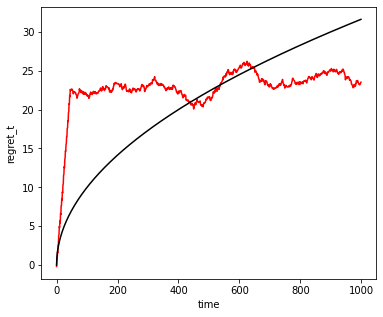

In [3]:
plt.figure(figsize=(6,5))
plt.plot(np.cumsum(expected_regrets), 'r')
plt.plot(np.sqrt(range(horizon)), 'k')
plt.xlabel('time')
plt.ylabel('regret_t')
plt.show()

### Conclusions of ETC
- Notice that the regret scales "approximately" as $\sqrt{t}$
- For $k > 2$, the algorithm is indeed unstable, and it is hard to obtain $\sqrt{n}$ bounds in all cases. Additionally, the optimal choice $m$ assumes knowledge of model parameters, can technically use elimination algorithm to make this data-dependent to obtain better results. might try it out later.
- the version implemented here is not an anytime algorithm -- can be rectified using "doubling trick".
- With respect to the movie recommendation system, the conclusion is that for more than $2$ movies, the algorithm is unstable. so not really practical!

## 2. Upper Confidence Bound
- As we saw in Lectures 1,2, we need a better algorithm for $k > 2$.
- Thus, we look at the UCB algorithm
- Recall that one parameter for UCB is the confidence interval, $\delta$. We will explore different choices in the next section.

#### Different choices of $\delta$
- Naive UCB uses 
    \begin{align}
    \delta_{naive} = \frac{1}{n^2}
    \end{align}
- Asymptotic Optimal UCB uses 
    \begin{align}
    \delta_{asymp} = \frac{1}{1 + t \log^2 t}
    \end{align}
- Minimax Optimal UCB uses 
    \begin{align}
    \delta_{MOSS} = \frac{k T_i(t-1)}{n}
    \end{align}

#### Recall that we required \delta < 1/n and observe that this is violated for MOSS. Thus, MOSS can "fail" sometimes but in certain settings, it is optimal (use large delta in code below to notice this)

In [4]:
##initialize model parameters
num_bandits = 10
delta = -10/num_bandits
means = np.concatenate((0, np.ones(num_bandits-1)* delta), axis=None)
variances = np.ones(num_bandits)
horizon = 1000
mc_iter = 30

##upper-confidence-bound parameters
# we will consider three values of delta (conf_int)
conf_int = 1/horizon **2;
log_val = np.zeros(3)
rewards = np.zeros((3, mc_iter, horizon))
regrets = np.zeros((3, mc_iter, horizon))

estimated_sums = np.zeros((3, num_bandits))
estimated_counts = np.zeros((3, num_bandits))

upper_confidence_bounds = 1e5 * np.ones((3, num_bandits))

actions = np.zeros((3, horizon))

##run the algorithm
for ii in range(mc_iter):
    for t_idx in range(horizon):
        for del_range in range(3):
            if (t_idx < num_bandits):
                actions[del_range, t_idx] = t_idx
            else:
                actions[del_range, t_idx] = np.argmax(upper_confidence_bounds[del_range, :])

            for arm in range(num_bandits):
                if (estimated_counts[del_range, arm] == 0):
                    upper_confidence_bounds[del_range, arm] = 1e5
                else:
                    if(del_range == 0):
                        log_val = np.log(1/conf_int)
                    elif(del_range == 1):
                        log_val = np.log(1 + (t_idx + 1) * (np.log(t_idx+1))  ** 2)
                    else:
                        log_val = 2 * np.log(np.max([1, horizon/(num_bandits * estimated_counts[2, arm])]))
                        
                    upper_confidence_bounds[del_range, arm] = (estimated_sums[del_range, arm]/estimated_counts[del_range, arm] 
                    + np.sqrt(2 * log_val/estimated_counts[del_range, arm]))

            current_reward = (means[int(actions[del_range, t_idx])] + np.sqrt(variances[int(actions[del_range, t_idx])]) 
                              * np.random.randn(1))
            estimated_counts[del_range, int(actions[del_range, t_idx])] += 1 
            estimated_sums[del_range, int(actions[del_range, t_idx])] += current_reward
            current_regret = means[0] -current_reward
            rewards[del_range, ii, t_idx] = current_reward
            regrets[del_range, ii, t_idx] = current_regret

expected_rewards = np.mean(rewards, axis=1)
expected_regrets = np.mean(regrets, axis=1)

##### Visualize results

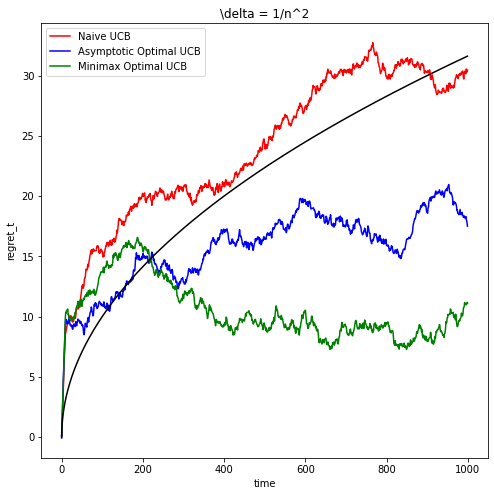

In [5]:
plt.figure(figsize=(8,8))
plt.plot(np.cumsum(expected_regrets[0,:]), 'r', label='Naive UCB')
plt.plot(np.cumsum(expected_regrets[1,:]), 'b', label='Asymptotic Optimal UCB')
plt.plot(np.cumsum(expected_regrets[2,:]), 'g', label='Minimax Optimal UCB')
plt.legend()
plt.plot(np.sqrt(range(horizon)), 'k')
plt.xlabel('time')
plt.ylabel('regret_t')
plt.title('\delta = 1/n^2')
plt.show()

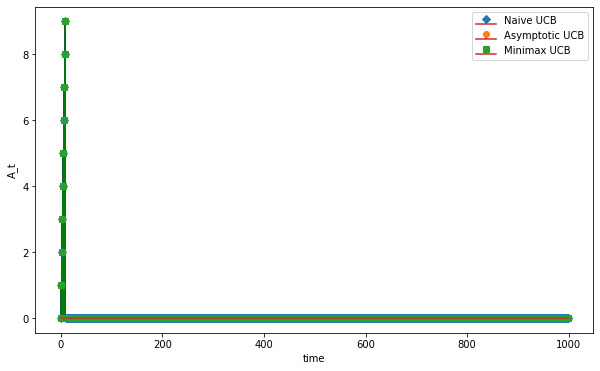

In [6]:
plt.figure(figsize=(10,6))
plt.stem(range(horizon), actions[0,:], 'r', linefmt='red', markerfmt='D',  label='Naive UCB')
plt.stem(range(horizon), actions[1,:], 'b', linefmt='blue', markerfmt='o', label='Asymptotic UCB')
plt.stem(range(horizon), actions[2,:], 'g', linefmt='green',  markerfmt='s', label='Minimax UCB')
plt.legend()
plt.xlabel('time')
plt.ylabel('A_t')

plt.show()

### Conclusions of UCB
- For $k > 2$, the results for all variants are significantly better than ETC. Thus, we can work with multiple movies to recommend using this approach.
- Numerically, with small $\Delta_i$ (sub-optimality gap), MOSS is the best variant but even the Naive version works well. in a movie setting, this translates to user "liking" all movies roughly to same extent. In a more practical scenario, Naive/Asymptotic UCB variants would be better. 

## B. Adversarial Bandits
- Now, the rewards are not chosen in a stochastic sense anymore. We assume that the adversary (environment) picks a sequence of rewards ahead of time.
- For now, I am generating the rewards as drawn from a 